# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [53]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os
from pathlib import Path

from bs4 import BeautifulSoup
from prettytable import PrettyTable

# [1]. Reading Data

In [3]:
path = Path('../data/amazon-fine-food/')
list(iter(path.iterdir()))

[PosixPath('../data/amazon-fine-food/database.sqlite')]

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect(path/'database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
df = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Exploratory analysis

In [5]:
df.shape

(568454, 10)

In [6]:
sns.set_style('whitegrid')

In [7]:
def sentiment_score(x):
    if x > 3:
        return 'positive'
    elif x < 3:
        return 'negetive'
    else:
        return 'neutral'

df['Sentiment'] = df.Score.map(sentiment_score)
print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (568454, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negetive
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negetive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


## Helpfulness

In [8]:
def helfulness_score(x):
    score = ''
    if x > 0.75:
        score = '>75%'
    elif x <= 0.75 and x >= 0.25:
        score = '25-75%'
    elif x < 0.25:
        score = '<25%'
    else:
        score = 'invalid'
    return score

df['helfulness'] = ((df.HelpfulnessNumerator / df.HelpfulnessDenominator)
                            .apply(helfulness_score))


df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,helfulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,>75%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negetive,invalid
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive,>75%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negetive,>75%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive,invalid


In [9]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

# changing reviews with score less than 3 to be negetive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
# Deduplication of entries
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)
final.shape

(364173, 10)

In [12]:
# Checking to see how much of data still remains
(final['Id'].size * 1.0) / (filtered_data['Id'].size*1.0) * 100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [15]:
final = final.sort_values(['Time'], axis=0)
final = final.head(30000)

In [16]:
final.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
443684,479746,B00005U2FA,A2QWI5SJZBCUX,"E. Stark ""mle54""",1,1,1,1199577600,Terrific!,I bought one of these wine savers for my husba...
21600,23647,B001E5DYSU,A38HD2D9KIQQMO,"C. Furman ""GoodLife""",6,7,1,1175731200,The ELITE coffee that is served to the Celebs,This coffee is amazing.. we stayed at the Shor...
280911,304354,B001AS1A4Q,AXLP17J20C2GC,Charles Balchunas,18,28,0,1201651200,Having the jitters is not being energetic,I was curious and tried this item on Jan 28th....
309054,334670,B001EO5R40,AKJXIL2VS3Y36,Basil Nestor,4,9,1,1183420800,Awesome taste!,I love this stuff! Wild Ride Gallopin' Pepper ...
49705,53975,B000EGZ2L2,A15XTEEDC4UNR6,Ashley,2,2,1,1211155200,Healthy Choice,My dogs have been on this food for three years...


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
    

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
stemmer = SnowballStemmer('english')

In [20]:
le=WordNetLemmatizer()

In [21]:
# Combining all the above
preprocessed_reviews = []
preprocessed_reviews_stem = []
preprocessed_reviews_lema = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence= sentence.lower().split()
    sentence_norm = ' '.join(e for e in sentence if e.lower() not in stopwords)
    sentence_stem = ' '.join(stemmer.stem(e) for e in sentence if e.lower() not in stopwords)
    sentence_lema = ' '.join(le.lemmatize(e) for e in sentence if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence_norm.strip())
    preprocessed_reviews_stem.append(sentence_stem.strip())
    preprocessed_reviews_lema.append(sentence_lema.strip())
    

In [22]:
preprocessed_reviews[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gifts husband'

In [23]:
preprocessed_reviews_stem[1500]

'best hot chocol first tri california hope one day could find local market excit find amazon get ship gift husband'

In [24]:
preprocessed_reviews_lema[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gift husband'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [25]:
preprocessed_summary = []
preprocessed_summary_stem = []
preprocessed_summary_lema = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence= sentence.lower().split()
    sentence_norm = ' '.join(e for e in sentence if e.lower() not in stopwords)
    sentence_stem = ' '.join(stemmer.stem(e) for e in sentence if e.lower() not in stopwords)
    sentence_lema = ' '.join(le.lemmatize(e) for e in sentence if e.lower() not in stopwords)
    preprocessed_summary.append(sentence_norm.strip())
    preprocessed_summary_stem.append(sentence_stem.strip())
    preprocessed_summary_lema.append(sentence_lema.strip())
    

In [26]:
preprocessed_summary[20000]

'excellent lemon flavor'

In [27]:
preprocessed_summary_stem[20000]

'excel lemon flavor'

In [28]:
preprocessed_summary_lema[20000]

'excellent lemon flavor'

In [29]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [30]:
len(preprocessed_reviews_lema)

30000

In [31]:
X_train = preprocessed_reviews_lema[:22000]
X_test = preprocessed_reviews_lema[22000:]
y_train = final.Score[:22000]
y_test = final.Score[22000:]
np.array(X_train).shape, np.array(X_test).shape, y_train.shape, y_test.shape

((22000,), (8000,), (22000,), (8000,))

### BAG OF WORDS

In [32]:
#BoW

count_vect = CountVectorizer(max_features = 5000)
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

In [68]:
X_train_bow.shape, X_test_bow.shape

((22000, 5000), (8000, 5000))

#### Logistic Regression

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [80]:
def model_accuracy(grid):
    print("Accuracy on train data= ", grid.best_score_*100)
    tr_acc1 = grid.best_score_*100
    a = grid.best_params_
    optimal_c = a.get('C')
    print(optimal_c)
    return optimal_c

In [81]:
def plot_model_result(grid, param_grid):
    neigh = [i for i in param_grid['C']]
    error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
    plt.plot(neigh, error)
    plt.title('Error plot')
    plt.xlabel('No. of Neighbors')
    plt.ylabel('Test_Error')
    plt.show()

In [82]:
def plot_confusion_matrix(y_test, pred):
    cm = confusion_matrix(y_test,pred)
    sns.heatmap(cm, annot=True,fmt='d')
    plt.title('Confusion Matrix for BoW')
    plt.show()

In [89]:
def test_scores(X_train, y_train, X_test, optimal_c, reg='l2'):
    clf_optimal = LogisticRegression(C=optimal_c, penalty=reg)
    clf_optimal.fit(X_train, y_train)

    pred = clf_optimal.predict(X_test)

    acc = accuracy_score(y_test, pred) * 100
    pre = precision_score(y_test, pred) * 100
    rec = recall_score(y_test, pred) * 100
    f1 = f1_score(y_test, pred) * 100
    
    print('\naccuracy=%f%%' % (acc))
    print('\nprecision=%f%%' % (pre))
    print('\nrecall=%f%%' % (rec))
    print('\nF1-Score=%f%%' % (f1))
    return pred, acc, pre, rec, f1


In [97]:
def build_model(X_train, y_train, X_test, y_test, param_grid, reg='l2'):
    clf = LogisticRegression(penalty=reg)
    param_grid = { 'C': [0.001,0.01,0.1,1,10] }
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs = 4)
    grid.fit(X_train, y_train)
    plot_model_result(grid, param_grid)
    optimal_c = model_accuracy(grid)
    pred, acc, pre, rec, f1 = test_scores(X_train, y_train, X_test, optimal_c, reg)
    plot_confusion_matrix(y_test, pred)
    return acc, pre, rec, f1, optimal_c

In [105]:
def print_values(acc1, reg1, pre1, rec1, f11, optimal_c1, acc2, reg2, pre2, rec2, f12, optimal_c2):
    x = PrettyTable()

    reg1 = 'L1'
    reg2 = 'L2'
    cv = 'Grid'
    x.field_names = ['CV', 'Regularizer', 'C', "Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]
    
    acc1 = np.around(acc1, decimals = 2)
    err1 = np.around(100-acc1, decimals = 2) 
    pre1 = np.around(pre1, decimals = 2)
    rec1 = np.around(rec1, decimals = 2)
    f11 = np.around(f11, decimals = 2)

    acc2 = np.around(acc2, decimals = 2)
    err2 = np.around(100-acc2, decimals = 2) 
    pre2 = np.around(pre2, decimals = 2)
    rec2 = np.around(rec2, decimals = 2)
    f12 = np.around(f12, decimals = 2)

    x.add_row([cv,reg1,optimal_c1,acc1,err1,pre1,rec1,f11])
    x.add_row([cv,reg2,optimal_c2,acc2,err2,pre2,rec2,f12])

    print(x)

In [109]:
def build_model_and_plot(X_train, y_train, X_test, y_test, param_grid):
    acc1, pre1, rec1, f11, optimal_c1 = build_model(X_train_bow, y_train, X_test_bow, y_test, param_grid, reg='l1')
    acc2, pre2, rec2, f12, optimal_c2 = build_model(X_train_bow, y_train, X_test_bow, y_test, param_grid, reg='l2')
    print_values(acc1, 'l1', pre1, rec1, f11, optimal_c1, acc2, 'l2', pre2, rec2, f12, optimal_c2)

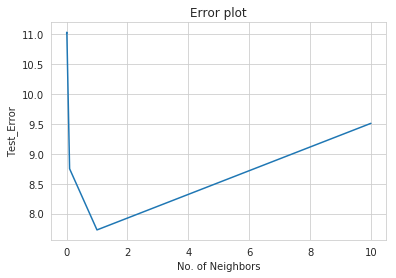

Accuracy on train data=  92.27272727272727
1

accuracy=93.050000%

precision=94.783784%

recall=97.633630%

F1-Score=96.187603%


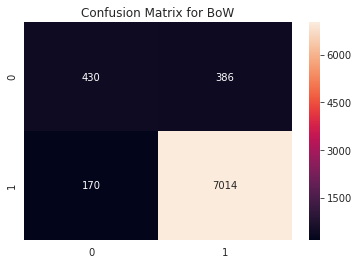

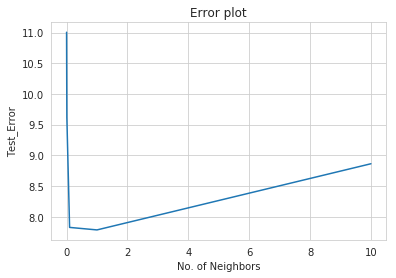

Accuracy on train data=  92.21363636363637
1

accuracy=93.225000%

precision=94.963444%

recall=97.633630%

F1-Score=96.280027%


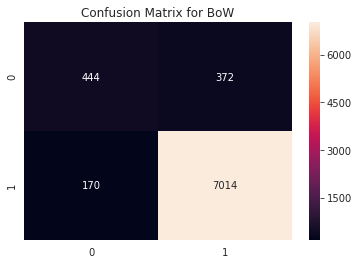

+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
| Grid |      L1     | 1 |    93.05    |      6.95     |    94.78     |   97.63   |    96.19    |
| Grid |      L2     | 1 |    93.22    |      6.78     |    94.96     |   97.63   |    96.28    |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+


In [111]:
param_grid = { 'C': [0.001,0.01,0.1,1,10] }
build_model_and_plot(X_train_bow, y_train, X_test_bow, y_test, param_grid)

## [4.2] Bi-Grams and n-Grams.

In [107]:
#bi-gram, tri-gram and n-gram

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=20000)
X_train_bigram = count_vect.fit_transform(X_train)
X_test_bigram = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_bigram))
print("the shape of out text TFIDF vectorizer ",X_test_bigram.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_test_bigram.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (8000, 12454)
the number of unique words including both unigrams and bigrams  12454


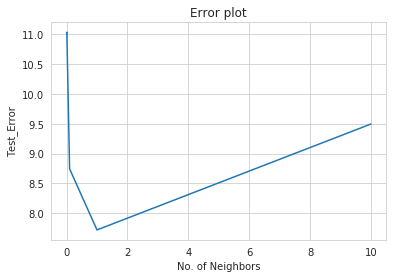

Accuracy on train data=  92.27727272727273
1

accuracy=93.050000%

precision=94.783784%

recall=97.633630%

F1-Score=96.187603%


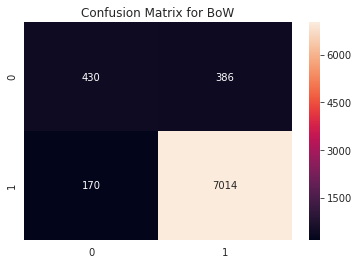

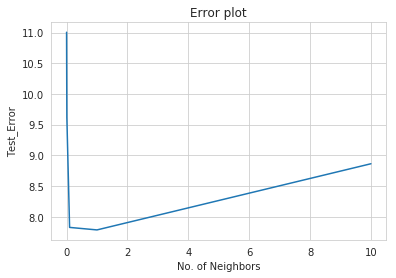

Accuracy on train data=  92.21363636363637
1

accuracy=93.225000%

precision=94.963444%

recall=97.633630%

F1-Score=96.280027%


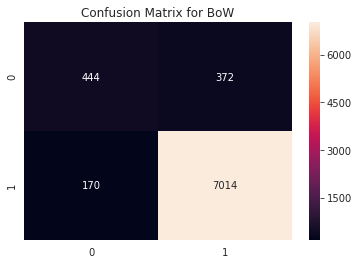

+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
| Grid |      L1     | 1 |    93.05    |      6.95     |    94.78     |   97.63   |    96.19    |
| Grid |      L2     | 1 |    93.22    |      6.78     |    94.96     |   97.63   |    96.28    |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+


In [112]:
param_grid = { 'C': [0.001,0.01,0.1,1,10] }
build_model_and_plot(X_train_bigram, y_train, X_test_bigram, y_test, param_grid)

In [ ]:
param_grid = { 'C': [0.001,0.01,0.1,1,10] }
acc2, pre2, rec2, f12, optimal_c2 = build_model(X_train_bigram, y_train, X_test_bigram, y_test, param_grid, reg=)

## [4.3] TF-IDF

In [50]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abandon', 'ability', 'able', 'able buy', 'able eat', 'able enjoy', 'able find', 'able get', 'able keep', 'able make']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30000, 12454)
the number of unique words including both unigrams and bigrams  12454


## [4.4] Word2Vec

In [51]:
# Train your own Word2Vec model using your own text corpus
i = 0
list_of_sentance = []
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [56]:
model_path = Path('../models')
list(iter(model_path.iterdir()))

[PosixPath('../models/GoogleNews-vectors-negative300.bin')]

In [57]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g= True
want_to_use_google_w2v = True
want_to_train_w2v = False

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile(model_path/'GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format(model_path/'GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.798933207988739), ('fantastic', 0.7935212254524231), ('tremendous', 0.7748855948448181), ('wonderful', 0.7647868990898132), ('good', 0.7291510701179504), ('incredible', 0.7032873630523682), ('marvelous', 0.6971102952957153), ('phenomenal', 0.6841564178466797), ('amazing', 0.6634127497673035), ('awesome', 0.6510507464408875)]
[('Worst', 0.6146091222763062), ('weakest', 0.6143776774406433), ('scariest', 0.5957258343696594), ('ugliest', 0.5931180119514465), ('best', 0.5835111141204834), ('bleakest', 0.5718506574630737), ('strongest', 0.5671455264091492), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624396204948425)]


In [58]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:100])

number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out', 'can', 'It', 'all', 'also', 'two', 'after', 'first', 'He', 'do', 'time', 'than', 'when', 'We', 'over', 'last', 'new', 'other', 'her', 'people', 'into', 'In', 'our', 'there', 'A', 'she', 'could', 'just', 'years', 'some', 'U.S.', 'three', 'million', 'them', 'what', 'But', 'so', 'no', 'like', 'if', 'only', 'percent', 'get', 'did', 'him', 'game', 'back', 'because', 'now', '#.#', 'before']


In [60]:
len(w2v_words)

3000000

In [61]:
final['Text'].shape

(19288,)